# CNN classification

This code has been developed starting from the the online [Pytorch Full Course video](https://www.youtube.com/watch?v=V_xro1bcAuA&t=53736s). This is done for making some practice in developing models from scratch using `torch` and `torchvision` libraries.

In [1]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

import os
from random import randint

## Dataset
For the example we'll use the `FashionMNIST` dataset directly available in `torchvision.datasets`.

### Load and visualize the dataset

Dataset Infos:

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

Classes: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

Data shape ((CxHxW), class), e.g. (torch.Size([1, 28, 28]), 9)


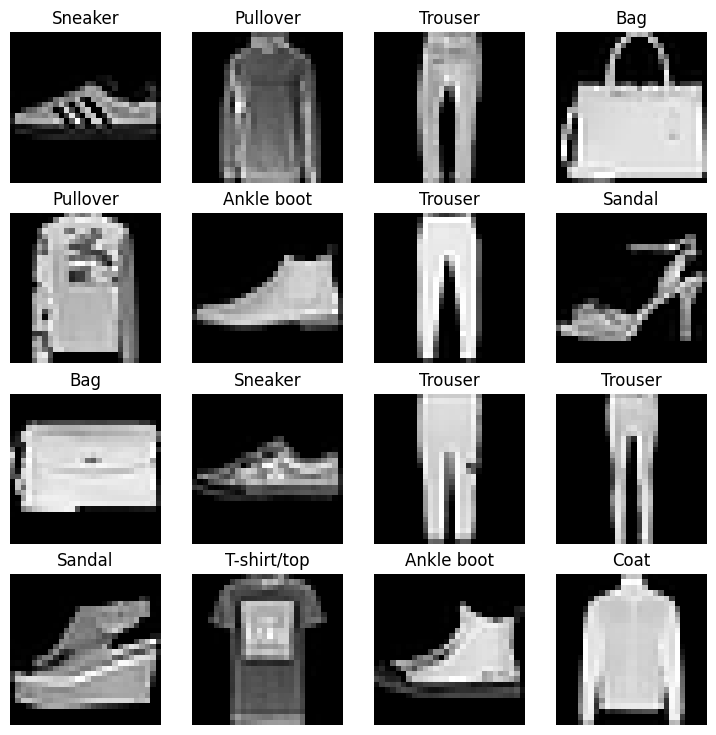

In [2]:
download = True if os.path.exists('Datasets/FashionMNIST') else False

# Load the training and testing dataset
train_dataset = datasets.FashionMNIST(download=True, root='Datasets', target_transform=None, transform=ToTensor(), train=True)
test_dataset = datasets.FashionMNIST(download=True, root='Datasets', target_transform=None, transform=ToTensor(), train=False)

# Print dataset infos
print(f'Dataset Infos:\n\n{train_dataset}\n\n{test_dataset}')
print(f'\nClasses: {train_dataset.class_to_idx}')
print(f'\nData shape ((CxHxW), class), e.g. ({train_dataset[0][0].shape}, {train_dataset[0][1]})')

# Print some examples
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    index = randint(0, len(train_dataset))
    img, label = train_dataset[index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(train_dataset.classes[label])
    plt.axis(False)

### Create a DataLoader
The dataloader is a python iterable, in this case we want to turn create batches of data. 

In [3]:
from torch.utils.data import DataLoader
import yaml

with open('./configs.yml', 'r') as f:
    configs = yaml.safe_load(f)
    f.close()

print(f'Loaded configuration from configs.yml:\n{configs}')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=configs['batch_size'], shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=configs['batch_size'], shuffle=False, num_workers=2)

imgs_batch_example, labels_batch_example = next(iter(train_dataloader))
print(f'\nBatches shape (img_batches, labels_batches): ({imgs_batch_example.shape}, {labels_batch_example.shape})')

Loaded configuration from configs.yml:
{'device': 'cuda', 'batch_size': 32, 'hidden_units': 256, 'lr': 0.01, 'epochs': 10, 'models_dir': 'TrainedModels'}

Batches shape (img_batches, labels_batches): (torch.Size([32, 1, 28, 28]), torch.Size([32]))


## First Model

All the model implementations are available at `models.py` file. We will start from a linear and non-linear model, the we'll develop CNN-based models to compare the results.

### Import the model

In [4]:
from models import FashionModelLinear

output_shape = len(train_dataset.classes)
channels, width, heigth = (imgs_batch_example.shape[1], imgs_batch_example.shape[2], imgs_batch_example.shape[3])
device = configs['device']

model_v0 = FashionModelLinear(img_width=width, img_height=heigth, hidden_units=configs['hidden_units'], output_shape=output_shape).to(device)

### Setup the loss, optimizer and evaluation metrics

In [5]:
import torch
from torch import nn

torch.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=configs['lr'])

### Create a training and testing loop

In [6]:
from tqdm import tqdm

from evaluation import get_accuracy

def evaluate_model(model: torch.nn.Module,
                   loss_fn: torch.nn.Module,
                   test_dataloader: torch.utils.data.DataLoader,
                   device: str):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
        model (torch.nn.Module): The neural network model to be evaluated.
        loss_fn (torch.nn.Module): The loss function used to compute the model's loss.
        test_dataloader (torch.utils.data.DataLoader): The DataLoader for the test dataset.
        device (str): The device to perform the evaluation on ('cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the model name, average loss, and accuracy on the test set.
    """
    
    test_loss, test_acc = 0.0, 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.inference_mode():  # Disable gradient computation for inference

        for images, labels in test_dataloader:
            # Move data to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute predictions
            predictions = model(images) 
            
            # Loss and accuracy calculation
            test_loss += loss_fn(predictions, labels)
            test_acc += get_accuracy(labels, predictions.argmax(dim=1))

        # Calculate the average loss and accuracy
        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

        return {
            "model_name": model.__class__.__name__,
            "model_test_loss": test_loss.to('cpu').item(),
            "model_test_accuracy": test_acc
        }
    


def train_model(model: torch.nn.Module, 
                loss_fn: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                device: str,
                epochs: int,
                optimizer: torch.optim.Optimizer):
    """
    Trains a PyTorch model over a specified number of epochs and evaluates it at the end of each epoch.

    Parameters:
        model (torch.nn.Module): The neural network model to train.
        loss_fn (torch.nn.Module): The loss function used to compute the loss during training.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        device (str): The device to use for training (e.g., 'cpu' or 'cuda').
        epochs (int): The number of epochs to train the model.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
    
    Returns:
        None: The function prints out the training loss and evaluation metrics at the end of each epoch.
    """

    # Calculate total number of batches (epochs * batches per epoch)
    total_batches = epochs * len(train_dataloader)

    epochs_test_results = []
    
    # Initialize a single tqdm progress bar for all batches
    progress_bar = tqdm(total=total_batches, desc="Training Progress", position=0, leave=True)

    for epoch in range(epochs):

        train_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            model.train()
            
            # Move data to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            predictions = model(images)
            
            # Loss calculation
            loss = loss_fn(predictions, labels)
            train_loss += loss.item()  # accumulate the loss for this batch

            # Optimizer zero grad
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()

            # Optimizer optimization 
            optimizer.step()
            
            # Update the progress bar
            progress_bar.update(1)
        
        # Adjust the training loss by averaging over the number of batches
        train_loss = train_loss / len(train_dataloader)
        
        # Testing and evaluation
        test_results = evaluate_model(model, loss_fn, test_dataloader, device)
        test_results['epoch'] = epoch
        epochs_test_results.append(test_results)

    for res in epochs_test_results:
        print(f"\n\nResults for epoch {res['epoch']}")
        print(f"Test Accuracy: {res['model_test_accuracy']:.4f}%   Test Loss: {res['model_test_loss']:.4f}")
    
    # Close the progress bar once training is complete
    progress_bar.close()


### Train the linear model

In [7]:
train_model(model=model_v0,
            loss_fn=loss_fn,
            train_dataloader=train_dataloader,
            device=device,
            epochs=configs['epochs'],
            optimizer=optimizer)

model_v0 = model_v0.to('cpu')

Training Progress: 100%|██████████| 18750/18750 [00:14<00:00, 1290.47it/s]



Results for epoch 0
Test Accuracy: 79.2831%   Test Loss: 0.6078


Results for epoch 1
Test Accuracy: 81.5395%   Test Loss: 0.5314


Results for epoch 2
Test Accuracy: 82.2883%   Test Loss: 0.5034


Results for epoch 3
Test Accuracy: 83.0671%   Test Loss: 0.4849


Results for epoch 4
Test Accuracy: 83.3866%   Test Loss: 0.4752


Results for epoch 5
Test Accuracy: 83.6362%   Test Loss: 0.4660


Results for epoch 6
Test Accuracy: 83.8958%   Test Loss: 0.4598


Results for epoch 7
Test Accuracy: 83.7560%   Test Loss: 0.4597


Results for epoch 8
Test Accuracy: 83.8758%   Test Loss: 0.4554


Results for epoch 9
Test Accuracy: 83.9557%   Test Loss: 0.4603


## Try a non-linear model

In [8]:
from models import FashionModelNonLinear

model_v1 = FashionModelNonLinear(img_width=width, img_height=heigth, hidden_units=configs['hidden_units'], output_shape=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model_v1.parameters(), lr=configs['lr'])
train_model(model=model_v1,
            loss_fn=loss_fn,
            train_dataloader=train_dataloader,
            device=device,
            epochs=configs['epochs'],
            optimizer=optimizer)

model_v1 = model_v1.to('cpu') # Move the model to the CPU to free the GPU memory

Training Progress: 100%|██████████| 18750/18750 [00:14<00:00, 1251.86it/s]



Results for epoch 0
Test Accuracy: 67.8115%   Test Loss: 1.0627


Results for epoch 1
Test Accuracy: 70.4673%   Test Loss: 0.9559


Results for epoch 2
Test Accuracy: 81.5395%   Test Loss: 0.5433


Results for epoch 3
Test Accuracy: 82.3083%   Test Loss: 0.5053


Results for epoch 4
Test Accuracy: 83.3866%   Test Loss: 0.4770


Results for epoch 5
Test Accuracy: 82.7576%   Test Loss: 0.4808


Results for epoch 6
Test Accuracy: 84.1753%   Test Loss: 0.4506


Results for epoch 7
Test Accuracy: 84.5847%   Test Loss: 0.4410


Results for epoch 8
Test Accuracy: 85.0339%   Test Loss: 0.4352


Results for epoch 9
Test Accuracy: 84.3251%   Test Loss: 0.4342


### Compare the two models results

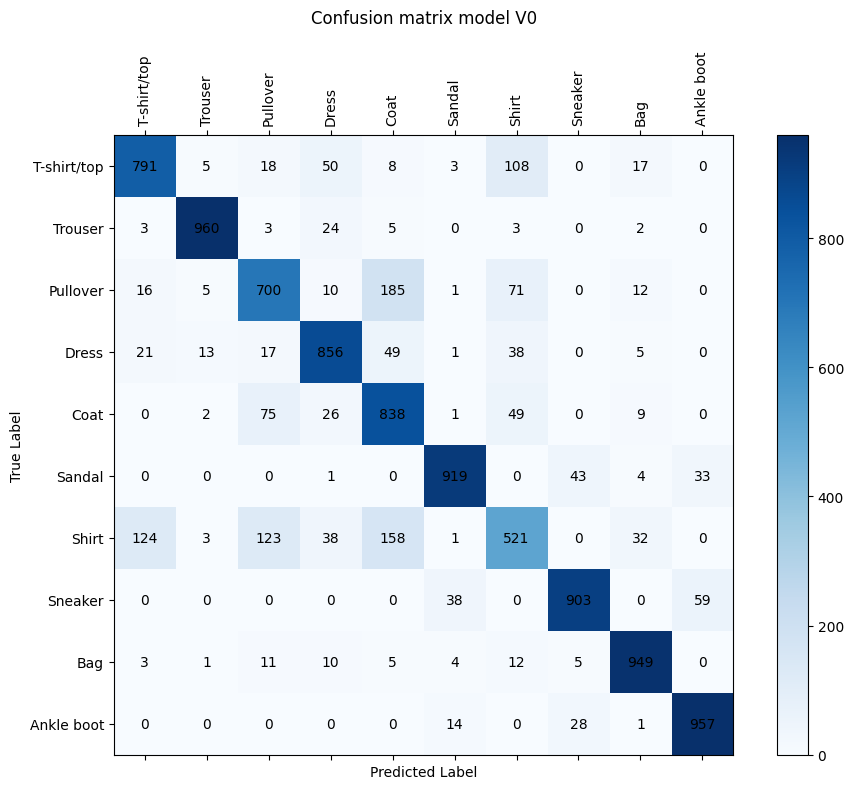

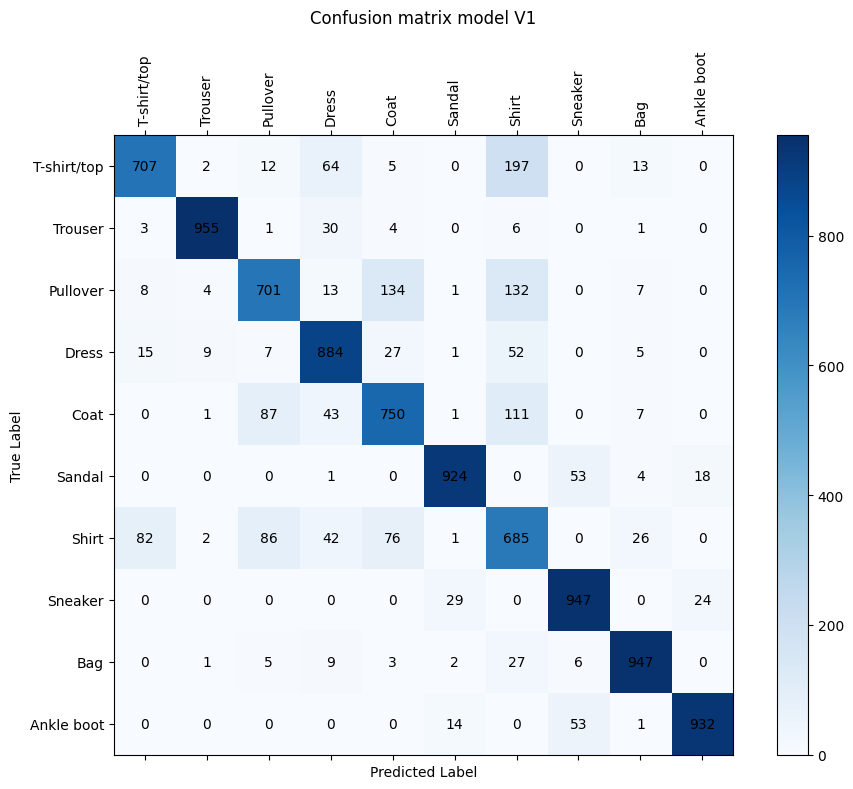

In [9]:
from evaluation import get_confusion_matrix, plot_confusion_matrix

confusion_matrix = None
with torch.inference_mode():
    model_v0 = model_v0.to(device) # Move the model into the GPU
    model_v0.eval()
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device) # Move the data into the GPU
        predictions = model_v0(images) # Forward step
        predictions = predictions.argmax(dim=1) # Get the class with highest probability score
        
        confusion_matrix = get_confusion_matrix(y_pred=predictions, y_true=labels, classes=len(train_dataset.classes), confusion_matrix=confusion_matrix)

    # Plot the final confusion matrix
    plot_confusion_matrix(confusion_matrix=confusion_matrix,
                          class_names=train_dataset.classes,
                          title='Confusion matrix model V0') 

model_v0 = model_v0.to('cpu') # Move the model to the CPU to free the GPU memory

confusion_matrix = None
with torch.inference_mode():
    model_v1 = model_v1.to(device) # Move the model into the GPU
    model_v1.eval()
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        predictions = model_v1(images) # Forward step
        predictions = predictions.argmax(dim=1) # Get the class with highest probability score

        confusion_matrix = get_confusion_matrix(y_pred=predictions, y_true=labels, classes=len(train_dataset.classes), confusion_matrix=confusion_matrix)


    plot_confusion_matrix(confusion_matrix=confusion_matrix,
                          class_names=train_dataset.classes,
                          title='Confusion matrix model V1')
    
model_v1 = model_v1.to('cpu') # Move the model to the CPU to free the GPU memory

## Start dealing with CNNs

Training Progress: 100%|██████████| 18750/18750 [02:03<00:00, 151.77it/s]



Results for epoch 0
Test Accuracy: 82.1486%   Test Loss: 0.4990


Results for epoch 1
Test Accuracy: 85.7228%   Test Loss: 0.3994


Results for epoch 2
Test Accuracy: 87.6098%   Test Loss: 0.3438


Results for epoch 3
Test Accuracy: 88.5583%   Test Loss: 0.3187


Results for epoch 4
Test Accuracy: 88.5583%   Test Loss: 0.3197


Results for epoch 5
Test Accuracy: 89.7764%   Test Loss: 0.2870


Results for epoch 6
Test Accuracy: 89.8263%   Test Loss: 0.2862


Results for epoch 7
Test Accuracy: 89.8562%   Test Loss: 0.2812


Results for epoch 8
Test Accuracy: 90.4653%   Test Loss: 0.2749


Results for epoch 9
Test Accuracy: 90.6749%   Test Loss: 0.2599


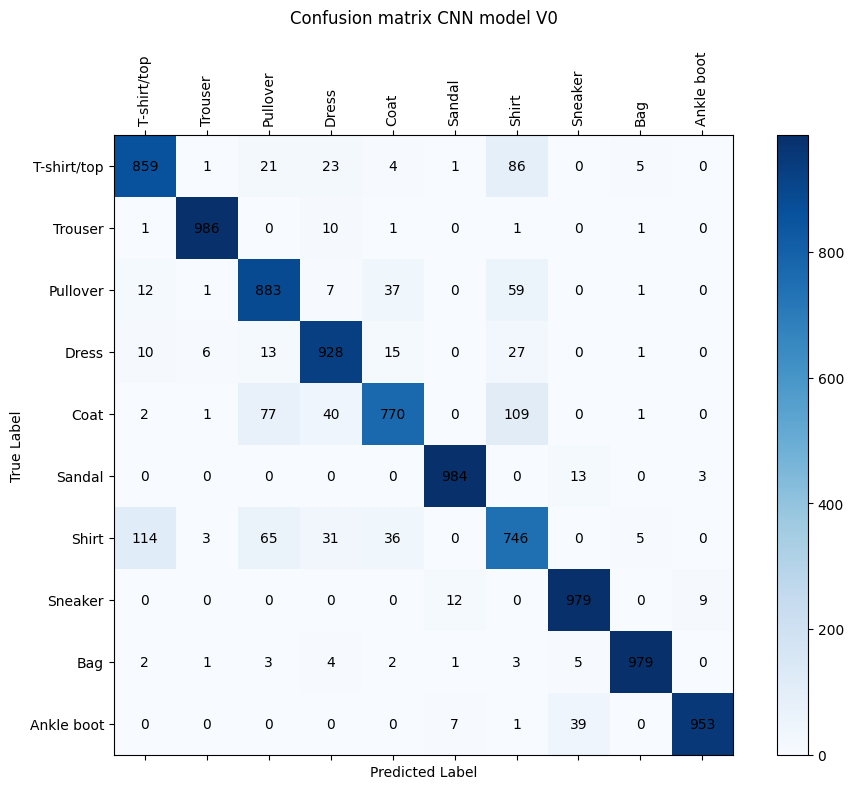

In [10]:
from models import FashionModelCnnV0

torch.manual_seed(42)

cnn_model_v0 = FashionModelCnnV0(img_channels=channels,
                              hidden_units=configs['hidden_units'],
                              output_shape=len(train_dataset.classes)).to(device)

optimizer = torch.optim.SGD(cnn_model_v0.parameters(), lr=configs['lr'])
loss_fn = nn.CrossEntropyLoss()

train_model(model=cnn_model_v0,
            loss_fn=loss_fn,
            train_dataloader=train_dataloader,
            device=device,
            epochs=configs['epochs'],
            optimizer=optimizer)

with torch.inference_mode():
    cnn_model_v0.eval()
    confusion_matrix = None
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        predictions = cnn_model_v0(images)
        predictions = predictions.argmax(dim=1) # Get the class with highest probability score
        confusion_matrix = get_confusion_matrix(labels, predictions, len(train_dataset.classes), confusion_matrix)
    
    plot_confusion_matrix(confusion_matrix=confusion_matrix,
                          class_names=train_dataset.classes,
                          title='Confusion matrix CNN model V0')

# Save the CNN model

In [11]:
from pathlib import Path

models_dir_path = Path(configs['models_dir'])
models_dir_path.mkdir(parents=True, exist_ok=True)
model_name = 'cnn_model_v0.pth'

print(f'Saving model to {models_dir_path / model_name}')
cnn_model_v0.to('cpu')
torch.save(cnn_model_v0.state_dict(), models_dir_path / model_name)

Saving model to TrainedModels/cnn_model_v0.pth
